### Example
Following the guide bellow:
- [spec2vec introduction I](https://blog.esciencecenter.nl/build-your-own-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-i-d96c718c68ee)
- [spec2vec introduction II](https://blog.esciencecenter.nl/build-a-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-ii-spec2vec-8aa639571018)

In [1]:
import os
import shutil
import urllib.request
from matplotlib import pyplot as plt
from matchms.importing import load_from_mgf
import re
from spec2vec import SpectrumDocument
from spec2vec.model_building import train_new_word2vec_model
from spec2vec import Spec2Vec
import matplotlib.pyplot as plt
from math import ceil
from rdkit import Chem
from rdkit.Chem import Draw
from matchms.similarity import ModifiedCosine
from matchms import calculate_scores
from matplotlib import pyplot as plt
import matchms.filtering as ms_filters
from matchms.exporting import save_as_mgf, save_as_msp
import pickle

In [2]:
TEMP_FOLDER = "source/temp"
os.makedirs(TEMP_FOLDER, exist_ok=False)

In [3]:
spectra_path = os.path.join(TEMP_FOLDER, "gnps_spectra_libary.mgf")
if not os.path.exists(spectra_path):
    urllib.request.urlretrieve("https://gnps-external.ucsd.edu/gnpslibrary/GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf", spectra_path)

spectrums = list(load_from_mgf(spectra_path))
len(spectrums) # how many spectra are in the library?

1267

In [4]:
# accessing the first spectrum
spectrum = spectrums[0]
spectrum.metadata

{'pepmass': (408.156, None),
 'charge': 1,
 'ionmode': 'positive',
 'smiles': 'OC(=O)[C@H](NC(=O)CCN1C(=O)[C@@H]2Cc3ccccc3CN2C1=O)c4ccccc4',
 'scans': '1865',
 'ms_level': '2',
 'instrument_type': 'LC-ESI-qTof',
 'file_name': 'p1-A05_GA5_01_17878.mzXML',
 'peptide_sequence': '*..*',
 'organism_name': 'GNPS-NIH-NATURALPRODUCTSLIBRARY',
 'compound_name': '"MLS001141366-01!(2R)-2-[3-[(10aS)-1,3-dioxo-10,10a-dihydro-5H-imidazo[1,5-b]isoquinolin-2-yl]propanoylamino]-2-phenylacetic acid" M+H',
 'principal_investigator': 'Dorrestein',
 'data_collector': 'VVP/LMS',
 'submit_user': 'vphelan',
 'confidence': '1',
 'spectrum_id': 'CCMSLIB00000079350',
 'precursor_mz': 408.156}

Here we visulize how many peaks are in most spectra.   
Most spectra contain many peaks this might very well be because of many small noise peaks. We will deal with that in our pipeline.

Text(0, 0.5, 'Number of spectra')

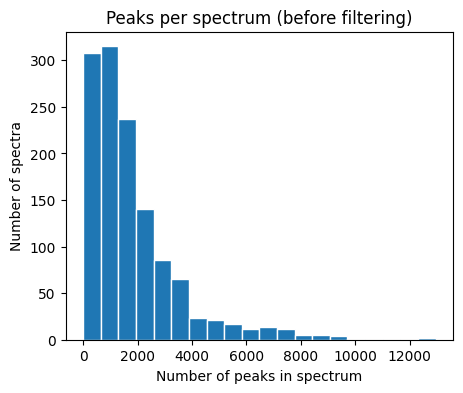

In [5]:
numbers_of_peaks = [len(s.peaks.mz) for s in spectrums]
plt.figure(figsize=(5,4), dpi=100)
plt.hist(numbers_of_peaks, 20, edgecolor="white")
plt.title("Peaks per spectrum (before filtering)")
plt.xlabel("Number of peaks in spectrum")
plt.ylabel("Number of spectra")

In [6]:
# saving in the original formats
save_as_mgf(spectrums, os.path.join(TEMP_FOLDER, "gnps_library_before.mgf"))
save_as_msp(spectrums, os.path.join(TEMP_FOLDER, "gnps_library_before.msp"))

c:\Users\aleks\anaconda3\envs\mass_spectra\lib\site-packages\pyteomics\mgf.py:772: UserWarning: Passing a single spectrum to `write()` is discouraged. To write a set of spectra, pass them to `write()` all at once. For more info, see: https://github.com/levitsky/pyteomics/discussions/109.
  warnings.warn("Passing a single spectrum to `write()` is discouraged. "


In [7]:
# faster saving using pickle for larger datasets
with open(os.path.join(TEMP_FOLDER, "gnps_library_before.pickle"), "wb") as fout:
    pickle.dump(spectrums, fout)

A typical preprocessing pipeline could consist of two parts, one to clean up the metadata and one to further process the peaks.

In [8]:
def metadata_processing(spectrum):
    spectrum = ms_filters.default_filters(spectrum) # general metadata cleaning
    spectrum = ms_filters.repair_inchi_inchikey_smiles(spectrum) # fix wrongly formatted InChI, InChIKey, SMILES
    spectrum = ms_filters.derive_inchi_from_smiles(spectrum) # derive InChI from SMILES
    spectrum = ms_filters.derive_smiles_from_inchi(spectrum) # derive SMILES from InChI
    spectrum = ms_filters.derive_inchikey_from_inchi(spectrum) # derive InChIKey from InChI
    spectrum = ms_filters.harmonize_undefined_smiles(spectrum) # replaces missing SMILES with a common placeholder
    spectrum = ms_filters.harmonize_undefined_inchi(spectrum) # replaces missing InChI with a common placeholder
    spectrum = ms_filters.harmonize_undefined_inchikey(spectrum) # replaces missing InChIKey with a common placeholder
    spectrum = ms_filters.add_precursor_mz(spectrum)
    return spectrum

In [9]:
def peak_processing(spectrum):
    spectrum = ms_filters.default_filters(spectrum) # general peak cleaning
    spectrum = ms_filters.normalize_intensities(spectrum) # normalize peak intensities to values between 0 and 1
    spectrum = ms_filters.select_by_intensity(spectrum, intensity_from=0.01) # remove peaks below 0.01 after normalization
    spectrum = ms_filters.select_by_mz(spectrum, mz_from=10, mz_to=1000) # remove peaks outside m/z range 10 to 1000
    return spectrum

In [10]:
from matchms.logging_functions import set_rdkit_logger_level
set_rdkit_logger_level("rdApp.error") # custom function implementation to set log level of RDKit (pending on pull request)

In [11]:
# preprocessing
spectrums = [metadata_processing(s) for s in spectrums]
spectrums = [peak_processing(s) for s in spectrums]

In [12]:
# save preprocessed data with pickle
with open(os.path.join(TEMP_FOLDER, "gnps_library_after.pickle"), "wb") as fout:
    pickle.dump(spectrums, fout)

Results of preprocessing:
- a lot less peaks
- richer metadata

Text(0, 0.5, 'Number of spectra')

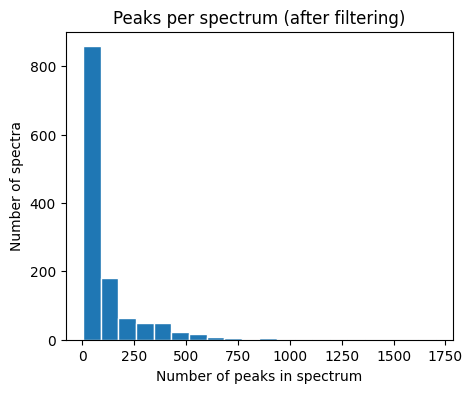

In [13]:
numbers_of_peaks = [len(s.peaks.mz) for s in spectrums]
plt.figure(figsize=(5,4), dpi=100)
plt.hist(numbers_of_peaks, 20, edgecolor="white")
plt.title("Peaks per spectrum (after filtering)")
plt.xlabel("Number of peaks in spectrum")
plt.ylabel("Number of spectra")

In [14]:
inchikeys = [s.get("inchikey") for s in spectrums]
inchikeys[:10]

['XTJNPXYDTGJZSA-PKOBYXMFSA-N',
 'VOYWJNWCKFCMPN-FHERZECASA-N',
 'IRZVHDLBAYNPCT-UHFFFAOYSA-N',
 'OPWCHZIQXUKNMP-RGEXLXHISA-N',
 'GTBYYVAKXYVRHX-BVSLBCMMSA-N',
 'UVZWLAGDMMCHPD-UHFFFAOYSA-N',
 'XKWILXCQJFNUJH-DEOSSOPVSA-N',
 'JDZNIWUNOASRIK-UHFFFAOYSA-N',
 'RCAVVTTVAJETSK-VXKWHMMOSA-N',
 'KQAZJQXFNDOORW-CABCVRRESA-N']

Discovering similarities
  
Steps:
- calculate similarity matrix
- use score_by_query to find the most similar spectra for a given query spectrum
- 

In [15]:
similarity_measure = ModifiedCosine(tolerance=0.005)
scores = calculate_scores(spectrums, spectrums, similarity_measure, is_symmetric=True) # calculate similarity scores based on similarity_measure

In [16]:
sorted_matches = scores.scores_by_query(spectrums[11], name="ModifiedCosine_score", sort=True) # best matches for spectrum 11

In [17]:
N_BEST = 10
MIN_MATCH_PEAKS = 5 # minimum number of peaks that need to match
best_matches = [x for x in sorted_matches if x[1][1] >= MIN_MATCH_PEAKS][:N_BEST] # top 10 matches

In [18]:
best_matches # first element is the matching spectrum, second element is the score. Score includes similarity score and number of matching peaks

[(<matchms.Spectrum.Spectrum at 0x1cc77b79f40>, (1., 151)),
 (<matchms.Spectrum.Spectrum at 0x1cc78d8b700>, (0.95295779, 15)),
 (<matchms.Spectrum.Spectrum at 0x1cc77bc2fa0>, (0.94542762, 13)),
 (<matchms.Spectrum.Spectrum at 0x1cc77c6f880>, (0.89735889, 17)),
 (<matchms.Spectrum.Spectrum at 0x1cc77cf6460>, (0.7886489, 12)),
 (<matchms.Spectrum.Spectrum at 0x1cc77cf2880>, (0.77433041, 9)),
 (<matchms.Spectrum.Spectrum at 0x1cc78cd97c0>, (0.74935776, 8)),
 (<matchms.Spectrum.Spectrum at 0x1cc78d34d00>, (0.72854032, 8)),
 (<matchms.Spectrum.Spectrum at 0x1cc78d867c0>, (0.55896333, 7)),
 (<matchms.Spectrum.Spectrum at 0x1cc77cc83a0>, (0.52331993, 9))]

In [19]:
saved_paths = []
for i, smiles in enumerate([x[0].get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    path = os.path.join(TEMP_FOLDER, "best_match_{}.png".format(i))
    Draw.MolToFile(m, path)
    saved_paths.append(path)

Displayed compounds do show some structural similarities.

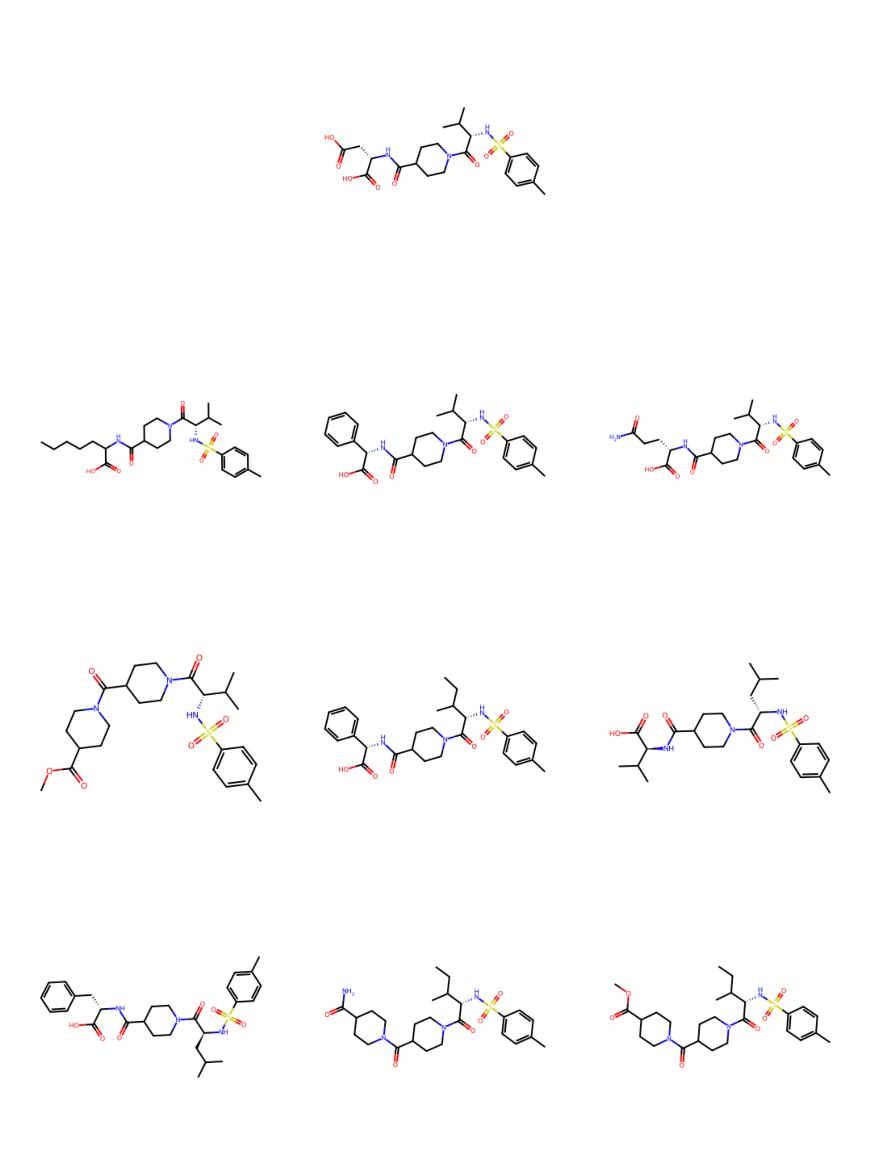

In [20]:
columns = 3
rows = int(1 + ceil((N_BEST - 1) / columns))
fig, axes = plt.subplots(rows, columns, figsize=(columns, rows), dpi=300)

for a in axes.flatten():
    a.axis("off")

axes[0, 1].imshow(plt.imread(saved_paths[0]))
for i in range(1, len(saved_paths)):
    row = (i - 1) // columns + 1
    col = (i - 1) % columns
    axes[row, col].imshow(plt.imread(saved_paths[i]))

plt.tight_layout()
plt.show()

Load preprocessed data with pickle

In [21]:
spectrums = pickle.load(open(os.path.join(TEMP_FOLDER, "gnps_library_after.pickle"), "rb"))

Loading a pretrained model (models can be trained on own data but it requires at least several hundred spectra to get good results).  
Avaliable at [https://zenodo.org/record/4173596](https://zenodo.org/record/4173596)

In [22]:
import gensim
model_name = "spec2vec_model_GNPS_all_positive"
model_file = os.path.join(TEMP_FOLDER, f"{model_name}.model")
model_trainable_file = os.path.join(TEMP_FOLDER, f"{model_name}.model.trainables.syn1neg.npy")
model_vectors_file = os.path.join(TEMP_FOLDER, f"{model_name}.model.wv.vectors.npy")
if not os.path.exists(model_file):
    urllib.request.urlretrieve("https://zenodo.org/record/4173596/files/spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model?download=1", model_file)
if not os.path.exists(model_trainable_file):
    urllib.request.urlretrieve("https://zenodo.org/record/4173596/files/spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy?download=1", model_trainable_file)
if not os.path.exists(model_vectors_file):
    urllib.request.urlretrieve("https://zenodo.org/record/4173596/files/spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy?download=1", model_vectors_file)

model = gensim.models.Word2Vec.load(model_file)

In [ ]:
# model vocabulary (decimal places tell us on what precision the model was trained)
model.wv.index_to_key[0]

'peak@105.07'

Using the model to calculate similarity between spectra.
- intensity_weighting_power = how much we scale each vector in abstract embedding space
- allowed_missing_percentage = what percentage (from 0 to 100) of spectrum can be missing in order to calculate similarity

In [ ]:

spec2vec_similarity = Spec2Vec(model=model, intensity_weighting_power=0.5, allowed_missing_percentage=5.0)

In [ ]:
scores = calculate_scores(spectrums, spectrums, spec2vec_similarity, is_symmetric=True)

In [ ]:
sorted_matches = scores.scores_by_query(spectrums[11], sort=True)

In [ ]:
sorted_matches[0] # the second element now only has a similarity score since in abstract space there is no concept of matching peaks

(<matchms.Spectrum.Spectrum at 0x2199472c910>, 0.9999999999999994)

In [ ]:
N = 10
best_matches = [x for x in sorted_matches][:N]

In [ ]:
best_matches

[(<matchms.Spectrum.Spectrum at 0x2199472c910>, 0.9999999999999994),
 (<matchms.Spectrum.Spectrum at 0x219929641f0>, 0.6323327469158129),
 (<matchms.Spectrum.Spectrum at 0x21982df3730>, 0.6094968210816908),
 (<matchms.Spectrum.Spectrum at 0x2198cbb2940>, 0.5633651650965529),
 (<matchms.Spectrum.Spectrum at 0x219999b8250>, 0.532211381301199),
 (<matchms.Spectrum.Spectrum at 0x21999991550>, 0.5311480111999451),
 (<matchms.Spectrum.Spectrum at 0x21999997610>, 0.49455675109741976),
 (<matchms.Spectrum.Spectrum at 0x2199e819b80>, 0.48921947174118874),
 (<matchms.Spectrum.Spectrum at 0x21982ded250>, 0.4697946531301545),
 (<matchms.Spectrum.Spectrum at 0x21984668460>, 0.4092511656226544)]

In [ ]:

saved_paths = []
for i, smiles in enumerate([x[0].get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    path = os.path.join(TEMP_FOLDER, "spec2vec_best_match_{}.png".format(i))
    Draw.MolToFile(m, path)
    saved_paths.append(path)

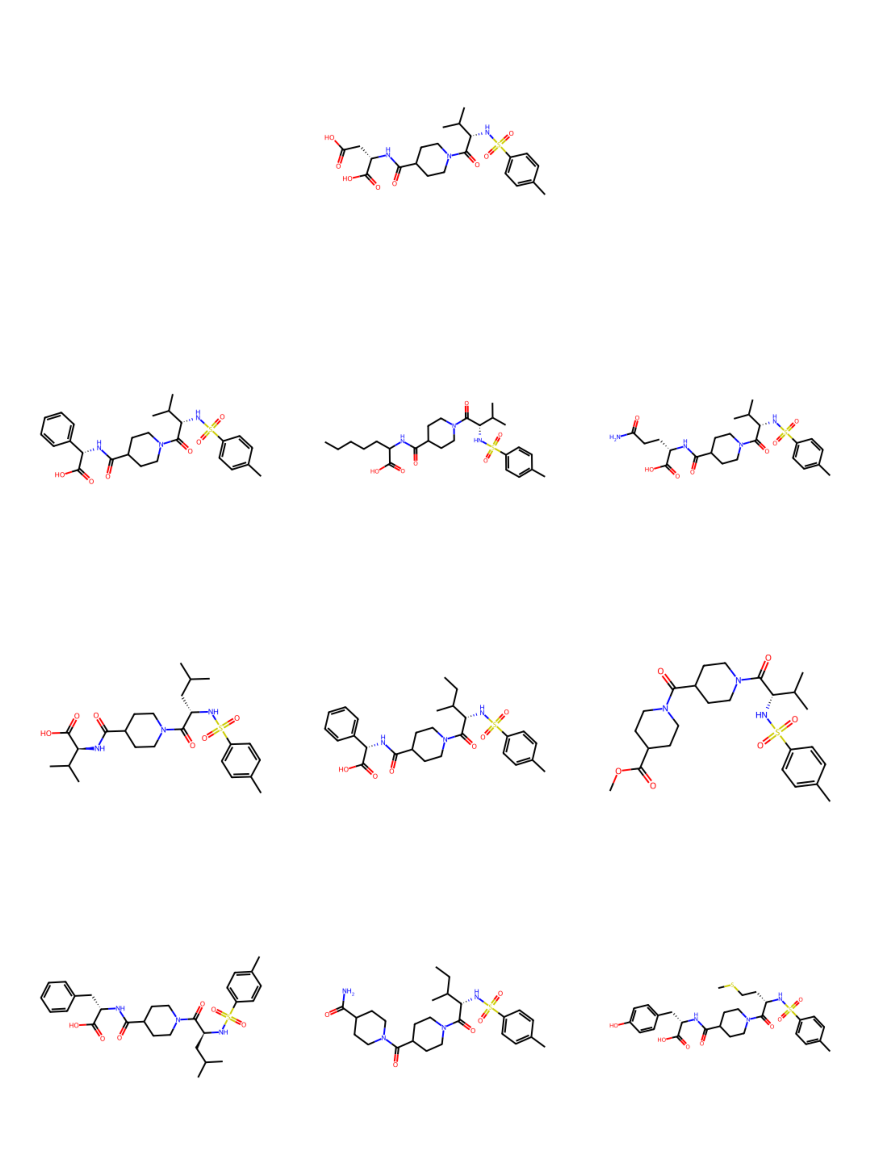

In [ ]:


columns = 3
rows = int(1 + ceil((N_BEST - 1) / columns))
fig, axes = plt.subplots(rows, columns, figsize=(columns, rows), dpi=300)

for a in axes.flatten():
    a.axis("off")

axes[0, 1].imshow(plt.imread(saved_paths[0]))
for i in range(1, len(saved_paths)):
    row = (i - 1) // columns + 1
    col = (i - 1) % columns
    axes[row, col].imshow(plt.imread(saved_paths[i]))

plt.tight_layout()
plt.show()

### Training from scratch

First we convert all spectrums to a SpectrumDocument object.

In [ ]:
spectrum_documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums]

In [ ]:
model_file = os.path.join(TEMP_FOLDER, "spec2vec_local.model")
model = train_new_word2vec_model(spectrum_documents, iterations=[10], filename=model_file,
                                 workers=2, progress_logger=True)

  Epoch 1 of 10.Change in loss after epoch 1: 274107.9375
  Epoch 2 of 10.Change in loss after epoch 2: 210388.84375
  Epoch 3 of 10.Change in loss after epoch 3: 195870.46875
  Epoch 4 of 10.Change in loss after epoch 4: 186039.6875
  Epoch 5 of 10.Change in loss after epoch 5: 177305.3125
  Epoch 6 of 10.Change in loss after epoch 6: 167528.875
  Epoch 7 of 10.Change in loss after epoch 7: 160589.625
  Epoch 8 of 10.Change in loss after epoch 8: 156970.375
  Epoch 9 of 10.Change in loss after epoch 9: 153058.5
  Epoch 10 of 10.Change in loss after epoch 10: 148080.375
Saving model with name: source/temp\spec2vec_local.model


Uisng the locally trained model is equivalent to using any other pretrained model. (see above)

Note from [https://blog.esciencecenter.nl/build-a-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-ii-spec2vec-8aa639571018](https://blog.esciencecenter.nl/build-a-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-ii-spec2vec-8aa639571018):  
"In our [Spec2Vec](https://www.biorxiv.org/content/10.1101/2020.08.11.245928v2) paper we compared the different similarity scores (Cosine, modified Cosine, Spec2Vec) in much more detail and found that Spec2Vec often — but not always — outperformed the classical scores. We also found a general trend that such scores are generally more reliable for larger compounds, supposedly because those will come with a higher number of chemically meaningful fragments."

There is a further tutorial on molecular networking as [part III](https://blog.esciencecenter.nl/build-a-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-iii-molecular-91891248ee34) of the series...

### Training on local data

In [ ]:
from matchms import set_matchms_logger_level
set_matchms_logger_level("ERROR") # set logging level to "ERROR" to avoid too many messages

In [ ]:
spectrums = list(load_from_mgf("./source/dataset/Test dataset_TBDMS_RAW.mgf"))
len(spectrums)

1936

In [ ]:
spectrums[0].metadata

{'mass': '236.3822',
 'charge': 1,
 'title': 'InChiKey: GPSVOHKZRIFVOF-UHFFFAOYSA-N, Name: Benzoic acid, TBDMS derivative'}

In [ ]:
inchi_name = re.compile("InChiKey:\s*([A-Z\-]+).*Name: (.*)")
for s in spectrums:
    inchikey, name = inchi_name.findall(s.metadata.get("title"))[0]
    s.set("inchikey", inchikey)
    s.set("compound_name", name)

In [ ]:
spectrums[0].metadata

{'mass': '236.3822',
 'charge': 1,
 'title': 'InChiKey: GPSVOHKZRIFVOF-UHFFFAOYSA-N, Name: Benzoic acid, TBDMS derivative',
 'inchikey': 'GPSVOHKZRIFVOF-UHFFFAOYSA-N',
 'compound_name': 'Benzoic acid, TBDMS derivative'}

In [ ]:
spectrums = [metadata_processing(s) for s in spectrums]
spectrums = [peak_processing(s) for s in spectrums]

In [ ]:
spectrums[0].metadata

{'mass': '236.3822',
 'charge': 1,
 'title': 'InChiKey: GPSVOHKZRIFVOF-UHFFFAOYSA-N, Name: Benzoic acid, TBDMS derivative',
 'inchikey': 'GPSVOHKZRIFVOF-UHFFFAOYSA-N',
 'compound_name': 'Benzoic acid, TBDMS derivative',
 'ionmode': 'n/a',
 'inchi': '',
 'smiles': ''}

In [ ]:
documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums]

In [ ]:
model_file = os.path.join(TEMP_FOLDER, "spec2vec_local.model")
model = train_new_word2vec_model(documents, iterations=[5])

  Epoch 1 of 5.Change in loss after epoch 1: 96042.1796875
  Epoch 2 of 5.Change in loss after epoch 2: 89986.8046875
  Epoch 3 of 5.Change in loss after epoch 3: 79417.546875
  Epoch 4 of 5.Change in loss after epoch 4: 74269.03125
  Epoch 5 of 5.Change in loss after epoch 5: 77191.28125


In [ ]:
model.save(model_file)

### Using the model

In [ ]:
import gensim

In [ ]:
model = gensim.models.Word2Vec.load(model_file)

In [ ]:
from spec2vec import Spec2Vec
spec2vec_similarity = Spec2Vec(model=model, intensity_weighting_power=0.5, allowed_missing_percentage=5.0)

In [ ]:
from matchms import calculate_scores
scores = calculate_scores(spectrums, spectrums, spec2vec_similarity, is_symmetric=True)

In [ ]:
sorted_matches = scores.scores_by_query(spectrums[11], sort=True)

In [ ]:
sorted_matches[1][0].get("compound_name")

'Benzoic acid, TBDMS derivative'

In [ ]:
spectrums[11].get("compound_name").split(",")[0]

'Benzoic acid'

Text(0.5, 0, 'm/z')

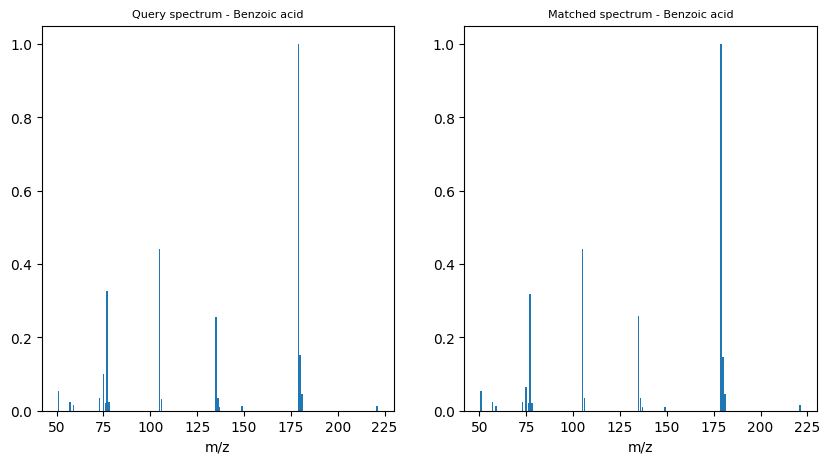

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.title("Query spectrum - {}".format(spectrums[11].get("compound_name").split(",")[0]), fontdict={"fontsize": 8})
plt.bar(spectrums[11].peaks.mz, spectrums[11].peaks.intensities, label="Query spectrum")
plt.xlabel("m/z")

plt.subplot(1, 2, 2)
plt.title("Matched spectrum - {}".format(sorted_matches[1][0].get("compound_name").split(",")[0]), fontdict={"fontsize": 8})
plt.bar(sorted_matches[1][0].peaks.mz, sorted_matches[1][0].peaks.intensities, label="Matched spectrum")
plt.xlabel("m/z")

In [ ]:
if input("Remove Temp Files? (y/n)") == "y":
    shutil.rmtree(TEMP_FOLDER)